### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip drive/My\ Drive/sign_data.zip

In [ ]:
import os
import copy
import time
import torch
import torchvision
import numpy as np
import pandas as pd 
import PIL.ImageOps 
import torch.nn as nn
from PIL import Image
from torch import optim
import torchvision.utils
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as utils
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from sklearn import preprocessing

### Files Paths

In [ ]:
data_dir = '/content/sign_data/'
train_csv = data_dir + 'train_data.csv'
test_csv = data_dir + 'test_data.csv'
train_dir = data_dir + 'train'
test_dir = data_dir + 'test'

### Data Loading

In [ ]:
class SiameseDataset():
  
  def __init__(self, df_csv=None, dir_path=None, mode=None):
    self.df = df_csv
    self.dir = dir_path
    self.mode = mode
    self.modes = ['train', 'test']

  def __getitem__(self, index):
    if self.mode == self.modes[0]:
      return self.get_train_row(index)
    elif self.mode == self.modes[1]:
      return self.get_test_row(index)

  def get_train_row(self, index):
    im0 = self.transform(Image.open(self.dir + '/' + self.df.iat[index,0]))
    im1 = self.transform(Image.open(self.dir + '/' + self.df.iat[index,1]))
    im2 = self.transform(Image.open(self.dir + '/' + self.df.iat[index,2]))
    return im0, im1, im2

    
  def get_test_row(self, index):
    im0 = self.transform(Image.open(self.dir + '/' + self.df.iat[index,0]))
    im1 = self.transform(Image.open(self.dir + '/' + self.df.iat[index,1]))
    label = torch.from_numpy(np.array([int(self.df.iat[index,2])],dtype=np.float32))
    return im0, im1, label

  def transform(self, img):
    img = img.convert('L')
    img = img.resize((105, 105))
    trans = transforms.ToTensor()
    return trans(img)

  def __len__(self):
        return len(self.df)

In [ ]:
def generate_triplets(csv):
  df = pd.read_csv(csv, header=None,  names=['p1', 'p2', 'label'])
  df_gen_pair = df[df.label == 0]
  df_forg_pair = df[df.label == 1]
  df_triplets = pd.DataFrame()

  i = -1
  for row in df_forg_pair.iterrows():
    i += 1
    tmpdf = df_gen_pair[df_gen_pair.p1 == row[1].p1]
    tmpdf.label = row[1].p2
    df_triplets = df_triplets.append(tmpdf)
    if i == 1000:
      break

  df_triplets = df_triplets.reset_index(drop=True)
  return df_triplets 

In [ ]:
def load_data(dir=None, csv=None, mode=None):
    if mode == 'train':
      df = generate_triplets(csv)
      df.columns =['Anchor', 'Positive', 'Negative']
      dataset = SiameseDataset(df, dir, 'train')
    elif mode == 'test':
      df = pd.read_csv(csv, header=None)
      df.columns =['Genuine', 'Unknown', 'Label']
      dataset = SiameseDataset(df, dir, 'test')
    return dataset

### Display Image

In [ ]:
def display(img, display_text):
    img_vector = img.numpy()
    plt.axis("off")
    plt.text(80, 10, display_text)
    plt.imshow(np.transpose(img_vector, (1, 2, 0)))
    plt.show()  

### Triplet Loss Function

In [ ]:
class TripletLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, img_anc, img_pos, img_neg):

        # Euclidean Distance
        d_pos = torch.sqrt(torch.sum(torch.square(img_anc - img_pos), dim=1))
        d_neg = torch.sqrt(torch.sum(torch.square(img_anc - img_neg), dim=1))

        zero_tensor = torch.zeros([d_pos.size()[0], 1], dtype=torch.float64)
        zero_tensor = zero_tensor.cuda()
        d_pos = d_pos.cuda()
        d_neg = d_neg.cuda()

        triplet_loss = torch.mean(torch.max(zero_tensor, (self.margin + d_pos - d_neg).double()))

        return triplet_loss

### Siamese Network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # CNN Layers set up
        self.layers = nn.Sequential(
            
            # Layer 1
            nn.Conv2d(1, 100, kernel_size=15,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            # Layer 2
            nn.Conv2d(100, 250, kernel_size=4,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            # Layer 3
            nn.Conv2d(250, 400, kernel_size=4,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),

            # Layer 4
            nn.Conv2d(400, 250, kernel_size=3,stride=2 ,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

        )
        
        # Connected layers
        self.conn_layers = nn.Sequential(
            nn.Linear(6250, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.4),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))

    def forward(self, input1):
        img_output = self.layers(input1)
        img_output = img_output.view(img_output.size()[0], -1)
        img_output = self.conn_layers(img_output)
        return img_output

### Train Network

In [ ]:
# Siamese Network
siamese_network = SiameseNetwork().cuda()

# Loss Function
loss_function = TripletLoss()

# Using Adam optimizer
optimizer_adam = optim.Adam(siamese_network.parameters(),lr = 0.0005)

In [ ]:
def train_model():
    dataset_obj = load_data(train_dir, train_csv, 'train')
    train_dataset = DataLoader(dataset_obj,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)
    
    total_epochs = 5 
    for epoch in range(0, total_epochs):
        for i, img_row in enumerate(train_dataset):
            # Clear old gradients
            optimizer_adam.zero_grad()

            anchor_img, gen_img , forge_img = img_row
            anchor_img, gen_img , forge_img = anchor_img.cuda(), gen_img.cuda() , forge_img.cuda()
            
            # Pass images through CNN
            anchor_output = siamese_network(anchor_img)
            gen_output = siamese_network(gen_img)
            forged_output = siamese_network(forge_img)

            dAP = dis(anchor_output, gen_output)
            dAN = dis(anchor_output, forged_output)

            # Calculate triplet loss and print
            triplet_loss = loss_function(anchor_output, gen_output, forged_output)
            if i % 200 == 0 :
                print("Epoch : ", epoch)
                print("Triplet Loss : ", triplet_loss.item())

            # Backward propogation
            triplet_loss.backward()

            # Take step based on upadated parameters
            optimizer_adam.step()

    return siamese_network

In [ ]:
# Train the model
model = train_model()
torch.save(model.state_dict(), "model_gen1.pt")
print("Model has been saved")

### Testing

In [ ]:
# Load the saved model
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load('model_gen1'))

<All keys matched successfully>

In [ ]:
def evaluate_predictions(df):
  count = 0
  one_median = df[df[0] == 1].mean()[1]
  zero_median = df[df[0] == 0].mean()[1]
  mid_point = (one_median - zero_median) / 2
  threshold = (one_median + mid_point)
  for row in df.iterrows():
    if row[1][1] < threshold:
      label == 0
    else:
      label == 1
    if row[1][0] == label:
      count += 1
    
  accuracy = count / df.index.size

Actual Label:  1.0


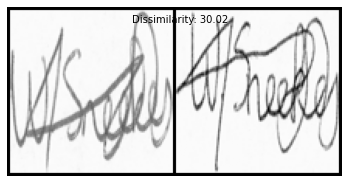




0  --
Actual Label:  1.0


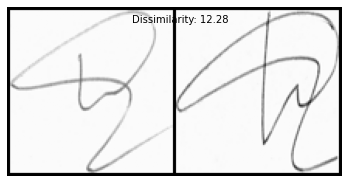




1  --
Actual Label:  1.0


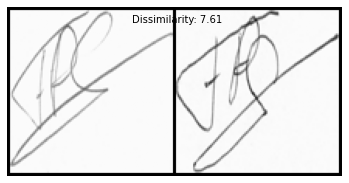




2  --
Actual Label:  0.0


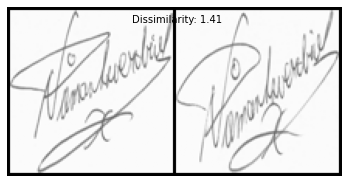




3  --
Actual Label:  0.0


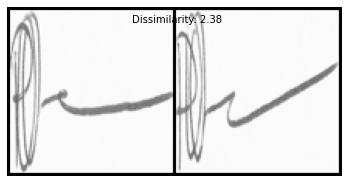




4  --
Actual Label:  1.0


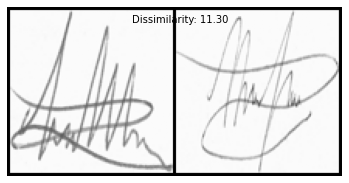

In [ ]:
dataset_obj = load_data(test_dir, test_csv, 'test')
test_dataset = DataLoader(dataset_obj,
                        shuffle=True,
                        num_workers=6,
                        batch_size=1)

norm_list = []

for i, data in enumerate(test_dataset):
  real_img, test_img, label = data
  
  joined_img = torch.cat((real_img, test_img), 0)
  real_img_output = model(real_img.to(device))
  test_img_output = model(test_img.to(device))


  # Distance between the two vectors
  l2_norm = torch.mean(torch.sqrt(torch.sum(torch.square(real_img_output - test_img_output), dim=1)))
  norm_list.append((label.item(), l2_norm.item()))

  print('Actual Label: ', label.item())
  display(torchvision.utils.make_grid(joined_img),'Dissimilarity: {:.2f}'.format(l2_norm))
  print('\n\n')

  # Displaying images for whole test dataset gives out of memory error.
  if i == 30:
    break

df_result = pd.DataFrame(norm_list)

